In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Algoritmo Kmeans:
class Kmeans:
  def __init__(self, n_clusters, max_iter=100, random_state=120, centroid_ini=[]):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.random_state = random_state
    self.centroid_ini = centroid_ini
  
  def inicializar_centroides(self, img):
    if len(self.centroid_ini):
      return self.centroid_ini

    np.random.seed(self.random_state)
    random_indx = np.random.permutation(self.n_pixels) # Genera una permutacion aleatoria
    centroides = img[random_indx[:self.n_clusters]] # Inicializa los centroides en puntos aleatorios de la imagen
    return centroides
  
  def calcular_distancias(self, img, centroides):
    distancias = np.zeros((self.n_pixels, self.n_clusters)) # Matriz de distancia
    for k in range(self.n_clusters):
      distancias[:, k] = np.sum((img-centroides[k])**2, axis=1)**(1/2) # Distancia euclidiana
    return distancias
    
  def calc_cluster_mas_cercano(self, distancias):
    return np.argmin(distancias, axis=1)

  def calcular_centroides(self, img, labels, centroides_prev):
    centroides = np.zeros((self.n_clusters, img.shape[1]))
    for k in range(self.n_clusters):
      pixels_k = labels==k
      if np.all(pixels_k==False):
        centroides[k] = centroides_prev[k]
      else:
        centroides[k] = np.mean(img[labels==k], axis=0)
    return centroides

  def compute(self, img):
    self.n_pixels = img.shape[0]
    centroides = self.inicializar_centroides(img)

    for i in range(self.max_iter):
      centroides_prev = centroides
      distancias = self.calcular_distancias(img, centroides_prev)
      labels = self.calc_cluster_mas_cercano(distancias)
      centroides = self.calcular_centroides(img, labels, centroides_prev)
      if np.all(centroides_prev==centroides):
        break
    
    return labels, centroides

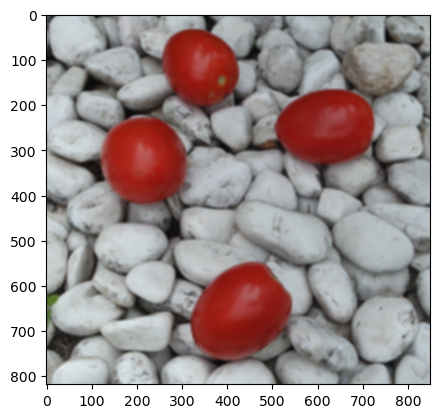

In [2]:
img = cv2.imread('Jit1.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

scale_percent = 30

width = int(img.shape[1]*scale_percent/100)
height = int(img.shape[0]*scale_percent/100)

img_r = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

img_blur = cv2.blur(img_r, (7,7))

plt.imshow(img_blur)
plt.show()

In [3]:
img_clustering = img_blur.reshape(-1,3).copy()
n_clusters = 5

labels, centroides = Kmeans(n_clusters).compute(img_clustering)

for k in range(n_clusters):
    img_clustering[labels==k] = centroides[k]

img_clustering = np.uint8(img_clustering.reshape((img_r.shape[0],img_r.shape[1],3)))

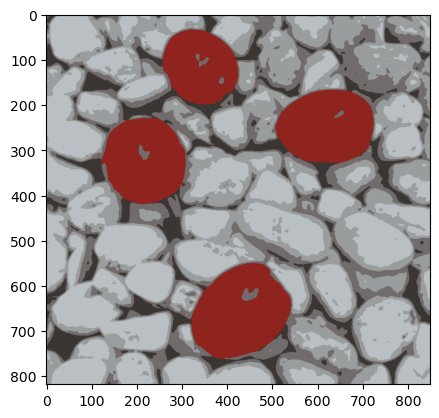

In [4]:
plt.imshow(img_clustering)

In [5]:
np.uint8(centroides)

array([[185, 191, 194],
       [113, 108, 107],
       [154, 157, 157],
       [142,  36,  29],
       [ 58,  54,  51]], dtype=uint8)

Color de jitomates: [142,36,29] (centroide 3)

Ahora obtenemos las coordenadas de los pixeles pertenecientes a un jitomate:

In [6]:
pixels_jitomates = np.transpose((np.all(img_clustering==np.uint8(centroides[3]), axis=2)).nonzero())

In [7]:
coord_labels, _ = Kmeans(4, random_state=22).compute(pixels_jitomates) # Agrupa los pixeles de cada jitomate

In [8]:
jitomates = []

for i in range(4):
    jitomates.append(pixels_jitomates[coord_labels==i])

In [9]:
img_jitomates = img_clustering.copy()

for i in range(4):
    color = np.random.randint(0,256,(3))
    img_jitomates[jitomates[i][:,0],jitomates[i][:,1]] = np.random.randint(0,256,(3))
    print(f"Jitomate {i} color: {color}")

Jitomate 0 color: [145 131  29]
Jitomate 1 color: [254 251  87]
Jitomate 2 color: [ 42  18 210]
Jitomate 3 color: [87  3 68]


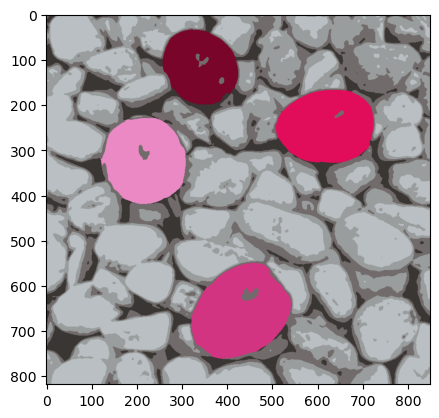

In [11]:
plt.imshow(img_jitomates)
plt.show()

In [17]:
def calcular_longitud(contornos, objetos):
    img_linea = img_r.copy()

    puntos = []
    distancia = []

    for i in objetos:
        countour_jit1 = []
        jit1 = jitomates[i]

        min_y = np.min(jit1[:,0])
        max_y = np.max(jit1[:,0])

        for y in range(min_y, max_y+1):
            fila = jit1[jit1[:,0]==y]

            izq = np.min(fila[:,1])
            der = np.max(fila[:,1])

            countour_jit1.append([y, izq])
            countour_jit1.append([y, der])

        min_x = np.min(jit1[:,1])
        max_x = np.max(jit1[:,1])

        for x in range(min_x, max_x+1):
            fila = jit1[jit1[:,1]==x]
            
            if len(fila):
                arriba = np.min(fila[:,0])
                abajo = np.max(fila[:,0])

                if not ([arriba, x] in countour_jit1):
                    countour_jit1.append([arriba, x])
                
                if not ([abajo, x] in countour_jit1):
                    countour_jit1.append([abajo, x])

        countour_jit1 = np.array(countour_jit1)

        distancias = []
        coordenadas = []

        for i in countour_jit1:
            for j in countour_jit1:
                distancias.append(int(((i[0]-j[0])**2+(i[1]-j[1])**2)**(1/2)))
                coordenadas.append([i,j])

        idx = np.argmax(distancias)
        p1 = coordenadas[idx][0]
        p2 = coordenadas[idx][1]

        x = np.array(range(min(p1[1],p2[1]),max(p1[1],p2[1])+1), np.int32)

        m = (p2[0]-p1[0])/(p2[1]-p1[1])

        c = p1[0]-m*p1[1]

        y = np.int32(m*x+c)

        for i in range(len(x)):
            img_linea[y[i]][x[i]] = np.array([0,0,0])
            img_linea[y[i]+1][x[i]] = np.array([0,0,0])
            img_linea[y[i]-1][x[i]] = np.array([0,0,0])
            img_linea[y[i]][x[i]+1] = np.array([0,0,0])
            img_linea[y[i]][x[i]-1] = np.array([0,0,0])

        puntos.append([p1,p2])
        distancia.append(np.max(distancias))
    
    return img_linea, puntos, distancia

In [18]:
img_linea, puntos, distancia = calcular_longitud(jitomates, [1,3])

In [21]:
plt.imshow(img_linea)

In [22]:
print(f"Puntos de medicion: Jitomate 1: {puntos[0][0]},{puntos[0][1]}, distancia={distancia[0]} pixeles")
print(f"Puntos de medicion: Jitomate 3: {puntos[1][0]},{puntos[1][1]}, distancia={distancia[1]} pixeles")

Puntos de medicion: Jitomate 1: [554 482],[757 367], distancia=233 pixeles
Puntos de medicion: Jitomate 3: [216 721],[252 507], distancia=217 pixeles


In [23]:
print(f"Distancia original jitomate 1: {distancia[0]//(scale_percent/100)}")
print(f"Distancia original jitomate 3: {distancia[1]//(scale_percent/100)}")

Distancia original jitomate 1: 776.0
Distancia original jitomate 3: 723.0
